In [1]:
from utils.experiment_utils import get_all_experiments_info, load_best_model
import torch
import os
import hydra
from omegaconf import DictConfig, OmegaConf

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

from tqdm.notebook import tqdm

from datasets.distribution_datasets import MultivariateNormalDistributionDataset

import scipy as sp

import matplotlib.patches as patches

In [2]:
device = 'cuda'
configs = get_all_experiments_info('/orcd/data/omarabu/001/gokul/DistributionEmbeddings/outputs/', False)
cfg = [c for c in configs if 'mvn_sys' in c['name']]

# load model and move to device
def load_model(cfg, path, device):
    enc = hydra.utils.instantiate(cfg['encoder'])
    gen = hydra.utils.instantiate(cfg['generator'])
    state = load_best_model(path)
    enc.load_state_dict(state['encoder_state_dict'])
    gen.model.load_state_dict(state['generator_state_dict'])
    enc.eval()
    gen.eval()
    enc.to(device)
    gen.to(device)
    return enc, gen

In [3]:
def wasserstein_zip(mu1, mu2, cov1, cov2):
    mean_dist = np.linalg.norm(mu1 - mu2, axis=1)
    var_dist = np.zeros(len(mu1))
    for i, (c1, c2) in enumerate(zip(cov1, cov2)):
        sqrt_c1 = sp.linalg.sqrtm(c1)
        prod = sqrt_c1 @ c2 @ sqrt_c1
        var_dist[i] = np.trace(c1 + c2 - 2 * sp.linalg.sqrtm(prod))
    return mean_dist + var_dist  # (n,)


def batch_cov(x):
    # x: (b, n, d)
    x = x - x.mean(dim=1, keepdim=True)     # center!
    cov = x.transpose(1, 2) @ x / (x.shape[1] - 1)  # sample cov :)
    return cov  # (b, d, d)

In [4]:
n_sets = 200

d = {
    "Encoder" : [],
    "Generator" : [],
    "N dims" : [],
    "OT reconstruction error" : [],
    'Parameter MSE' : []
}

for c in tqdm(cfg):
    encoder_name = c['encoder']
    generator_name = c['generator']

    if generator_name == 'DirectGenerator':
        generator_name += '-'+c['config']['generator']['loss_type']
        if 'mmd' in generator_name:
            continue
        
    data_shape = c['config']['dataset']['data_shape']
    print(encoder_name, generator_name, data_shape)
    try:
        enc, gen = load_model(c['config'], c['dir'], device=device)
    except:
        print("broken: ", encoder_name)
        continue

    if 'Tx' not in encoder_name and 'Wormhole' not in encoder_name:
        set_size = 10**4
    else:
        set_size=10**3

    # load dataset
    dataset = MultivariateNormalDistributionDataset(set_size=set_size,
                                                    n_sets=n_sets,
                                                    data_shape=data_shape
                                                           )
    
    mus = dataset.mu # shape: batch, d
    covs = dataset.cov # shape: batch, d, d


    rec_error = []
    mses = []
    for idx in range(len(dataset)//8):

        with torch.no_grad():
            x = torch.tensor(dataset.data[idx*8:(idx+1)*8], dtype=torch.float).cuda()
            z = enc(x)
            x_hat = gen.sample(z, num_samples=set_size)

        r_mus = x_hat.mean(axis=1).cpu().numpy()
        r_covs = batch_cov(x_hat).cpu().numpy()

        mu_mse = np.mean(np.linalg.norm(mus[idx*8:(idx+1)*8] - r_mus, axis=1))
        cov_mse = np.mean(np.linalg.norm(covs[idx*8:(idx+1)*8] - r_covs, axis=(1, 2)))


        rec_error.append(wasserstein_zip(mus[idx*8:(idx+1)*8], r_mus, covs[idx*8:(idx+1)*8], r_covs))
        mses.append(mu_mse + cov_mse)



    
    d["Encoder"].append(encoder_name)
    d["Generator"].append(generator_name)
    d["N dims"].append(data_shape[0])
    d["OT reconstruction error"].append(np.mean(rec_error))
    d['Parameter MSE'].append(np.mean(mses))


  0%|          | 0/36 [00:00<?, ?it/s]

KMEEncoder CVAE [5]
DistributionEncoderResNet WormholeGenerator [5]
[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
DistributionEncoderGNN DirectGenerator-swd [5]
DistributionEncoderMedianGNN DDPM [5]
KMEEncoder WormholeGenerator [5]
DistributionEncoderGNN WormholeGenerator [5]
DistributionEncoderMedianGNN DirectGenerator-swd [5]
KMEEncoder DirectGenerator-swd [5]
WormholeEncoder DirectGenerator-swd [5]
KMEEncoder DDPM [5]
KMEEncoder DirectGenerator-sinkhorn [5]
DistributionEncoderMedianGNN DirectGenerator-sinkhorn [5]
DistributionEncoderMedianGNN WormholeGenerator [5]
WormholeEncoder WormholeGenerator [5]
DistributionEncoderGNN DirectGenerator-sinkhorn [5]
DistributionEncoderResNet DirectGenerator-swd [5]
WormholeEncoder CVAE [5]
DistributionEncoderResNet CVAE [5]
MeanEncoder CVAE [5]
DistributionEncoderResNet DDPM [5]
DistributionEncoderMedianGNN CVAE [5]
DistributionEncoderGNN DDPM [5]
WormholeEncoder DirectGenerator-sinkhorn [5]
MeanEncoder

In [5]:
pd.DataFrame(d).sort_values('OT reconstruction error')

,Encoder,Generator,N dims,OT reconstruction error,Parameter MSE
19,DistributionEncoderResNet,DDPM,5,0.020520,0.040905
15,DistributionEncoderResNet,DirectGenerator-swd,5,0.028232,0.049019
23,MeanEncoder,DirectGenerator-swd,5,0.029406,0.050141
24,MeanEncoder,DDPM,5,0.031682,0.052457
9,KMEEncoder,DDPM,5,0.035308,0.056475
7,KMEEncoder,DirectGenerator-swd,5,0.042248,0.064558
8,WormholeEncoder,DirectGenerator-swd,5,0.043769,0.065910
27,MeanEncoder,DirectGenerator-sinkhorn,5,0.049649,0.073369
28,DistributionEncoderResNet,DirectGenerator-sinkhorn,5,0.050286,0.074897
3,DistributionEncoderMedianGNN,DDPM,5,0.054200,0.075360


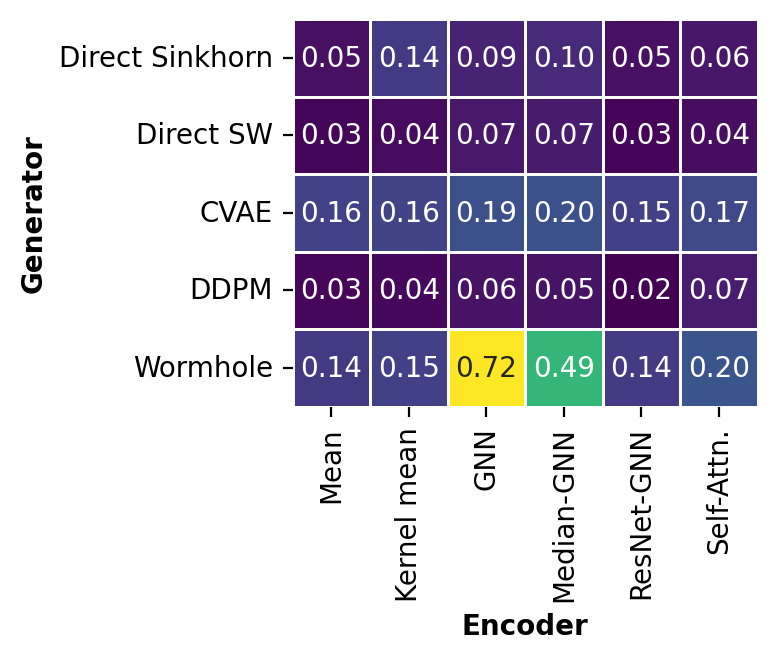

In [31]:
df = pd.DataFrame(d)

df.replace("DistributionEncoderGNN", "GNN", inplace=True)
df.replace("DistributionEncoderMedianGNN", "Median-GNN", inplace=True)
df.replace("DistributionEncoderResNet", "ResNet-GNN", inplace=True)
df.replace("MeanEncoder", "Mean", inplace=True)
df.replace('WormholeEncoder', 'Self-Attn.', inplace=True)
df.replace('DirectGenerator-sinkhorn', 'Direct Sinkhorn', inplace=True)
df.replace('DirectGenerator-swd', 'Direct SW', inplace=True)
df.replace('WormholeGenerator', 'Wormhole', inplace=True)
df.replace('KMEEncoder', 'Kernel mean', inplace=True)

plt.figure(figsize=(3, 3), dpi=200)

row_order = ['Direct Sinkhorn', 'Direct SW', 'CVAE', 'DDPM', 'Wormhole']
column_order = ['Mean', 'Kernel mean', 'GNN', 'Median-GNN', 'ResNet-GNN', 'Self-Attn.']

table = df.pivot_table(columns='Encoder', index='Generator', 
                           values='OT reconstruction error').reindex(index=row_order, columns=column_order) 

heatmap = sns.heatmap(table, 
            annot=True, fmt=".2f", cmap="viridis", 
            square=True, lw=0.5,
            cbar=False)

# Highlight the cell at row 4, column 5
row_idx = 3  # Zero-based index for the 5th row
col_idx = 4  # Zero-based index for the 6th column

# Get the position of the cell
x = col_idx
y = row_idx

# Add a rectangle to highlight the cell
# ax = heatmap.axes
# rect = patches.Rectangle((x, y), 1, 1, linewidth=3, edgecolor='aqua', linestyle='solid', facecolor='none')
# ax.add_patch(rect)

# rect = patches.Rectangle((x, 0.05), 1, 4.9, linewidth=1, edgecolor='green', linestyle='dashed', facecolor='none')
# ax.add_patch(rect)

# rect = patches.Rectangle((0.05, y), 5.9, 1, linewidth=1, edgecolor='green', linestyle='dashed', facecolor='none')
# ax.add_patch(rect)

# plt.xticks(rotation=60)
plt.xlabel('Encoder', fontweight='bold')
plt.ylabel('Generator', fontweight='bold')
# plt.xlabel('')
# plt.ylabel('')
# plt.text(-2, 0, 'Encoder', fontweight='bold', fontsize=12)
# plt.text(-0.25, 7.5, 'Generator', fontweight='bold', fontsize=12, rotation=90)


# plt.tight_layout()
plt.show()

In [8]:
table.to_csv('numerical_results/benchmark_mvn.csv')